# DESeq1
# Phase 2 vs. Phase 2

focusing on pairwise comparisons of oysters that experienced both phase 1 and phase 2

## 0. load libraries

In [2]:
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano)
library(vegan)

## 1. read counts matrix and meta data

### counts matrix

In [3]:
# counts matrix
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')

# set gene_ID as row name
rownames(counts) <- counts$Gene_ID

# remove gene id and length
counts.df <- counts %>%
select(-Gene_ID, -Length)

head(counts.df)

,B1_B1_O01,B1_Nu_O03,B1_W5_O50,B2_B5_O51,B2_C4_O40,B2_Nu_O12,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_Nu_G41,W6_Nu_G45,W6_W3_G36,W6_W4_G48
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
LOC111116054,2,1,6,10,9,16,0,10,22,9,⋯,9,2,8,5,2,19,1,2,1,0
LOC111126949,885,652,477,654,586,523,392,357,496,540,⋯,407,740,707,406,418,424,492,330,281,599
LOC111110729,64,209,93,63,100,177,76,98,235,181,⋯,70,149,121,115,126,108,118,115,127,213
LOC111112434,11,7,2,0,2,2,12,15,10,36,⋯,11,6,4,0,2,16,22,0,8,0
LOC111120752,360,586,336,426,351,417,236,278,761,373,⋯,359,345,438,278,287,416,621,251,333,430
LOC111128944,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,0


### meta data
the meta data csv was already generated in [deseq_p1.v.p1](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/deseq_p1.v.p1.ipynb), so just reading in here

In [4]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

head(meta)
dim(meta)

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5
B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5
B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4
B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4
B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3


[1] 96  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [5]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

# check
head(meta,2)
tail(meta,2)

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1,both both
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5,both warm


,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>,<chr>
W6_W3_G36,warm,warm,normoxic,6,warm,warm,normoxic,3,warm warm
W6_W4_G48,warm,warm,normoxic,6,warm,warm,normoxic,4,warm warm


In [6]:
# setting the same order for counts matrix and meta data
counts.df <- counts.df[,rownames(meta)]
all(rownames(meta) == colnames(counts.df))

[1] TRUE

## 2. DESeq2
analyzing differential gene expression with [`DESeq2`](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

#### contrasts
setting up contrasts (telling DESeq what is the control treatment)

In [7]:
# tempature treatments
meta$Phase1_temp <- factor(meta$Phase1_temp,
                                   levels = c('ambient', 'warm'))

meta$Phase2_temp <- factor(meta$Phase2_temp,
                                   levels = c('ambient', 'warm'))

In [8]:
# DO treatments
meta$Phase1_DO <- factor(meta$Phase1_DO,
                                   levels = c('normoxic', 'hypoxic'))

meta$Phase2_DO <- factor(meta$Phase2_DO,
                                   levels = c('normoxic', 'hypoxic'))

### complete treatments
starting simple with looking at phase 1 treatments (not splitting into temperature/DO, just looking at combination of treatments)

In [9]:
# creating DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = counts.df,
                              colData = meta,
                              design = ~ complete_trtmt)
dds

# running DESeq
dds <- DESeq(dds)

# list coefficients
resultsNames(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 38838 96 
metadata(1): version
assays(1): counts
rownames(38838): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(96): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



[1] "Intercept"                                  
 [2] "complete_trtmt_both.control_vs_both.both"   
 [3] "complete_trtmt_both.hypoxic_vs_both.both"   
 [4] "complete_trtmt_both.warm_vs_both.both"      
 [5] "complete_trtmt_control.both_vs_both.both"   
 [6] "complete_trtmt_control.control_vs_both.both"
 [7] "complete_trtmt_control.hypoxic_vs_both.both"
 [8] "complete_trtmt_control.warm_vs_both.both"   
 [9] "complete_trtmt_hypoxic.both_vs_both.both"   
[10] "complete_trtmt_hypoxic.control_vs_both.both"
[11] "complete_trtmt_hypoxic.hypoxic_vs_both.both"
[12] "complete_trtmt_hypoxic.warm_vs_both.both"   
[13] "complete_trtmt_warm.both_vs_both.both"      
[14] "complete_trtmt_warm.control_vs_both.both"   
[15] "complete_trtmt_warm.hypoxic_vs_both.both"   
[16] "complete_trtmt_warm.warm_vs_both.both"

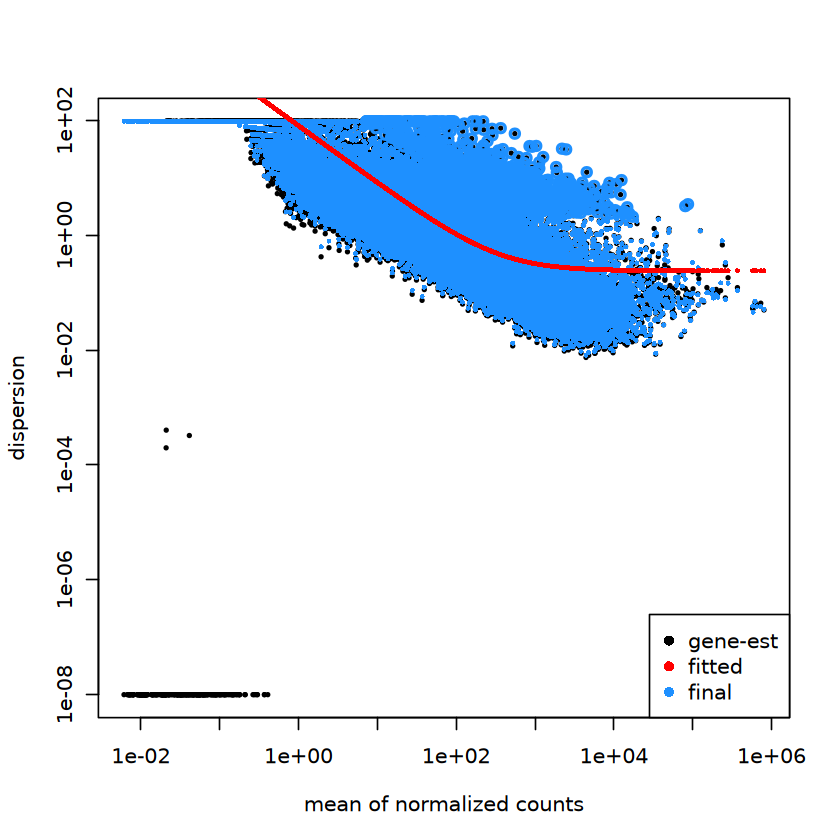

In [11]:
plotDispEsts(dds)

## nMDS
normalize and transform DESeq object using csv (variance stabilized expression matrix)

In [12]:
# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

,B1_B1_O01,B1_W5_O50,B2_B5_O51,B2_C4_O40,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,B3_W1_O06,B3_W4_O41,⋯,W4_W5_G56,W5_B2_G21,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48
B1_B1_O01,0.0000,112.87364,115.3262,107.89794,115.25554,113.48167,122.9179,116.1678,114.67824,105.7388,⋯,131.0135,110.9503,95.3255,104.5872,101.6345,105.9910,123.9108,108.3290,104.35939,129.5139
B1_W5_O50,112.8736,0.00000,109.3705,92.94934,92.51608,97.48152,101.4467,113.4727,106.26615,106.0474,⋯,108.4771,117.2177,110.3544,111.4573,111.7282,110.5900,114.0655,110.8031,104.15168,109.1279
B2_B5_O51,115.3262,109.37055,0.0000,115.95337,111.82418,118.24287,112.7788,125.5576,128.07360,123.0549,⋯,117.1577,129.0589,121.7444,105.0726,118.6173,123.0947,119.5198,123.0654,116.52978,109.4809
B2_C4_O40,107.8979,92.94934,115.9534,0.00000,99.34984,96.00067,108.4873,111.2476,112.74691,100.7027,⋯,114.3448,111.0231,107.5110,108.3220,106.9164,106.7425,121.0028,105.3548,84.68172,116.2580
B3_B4_O41,115.2555,92.51608,111.8242,99.34984,0.00000,105.68102,108.0776,119.5018,97.63448,111.9091,⋯,107.0356,120.5420,112.3259,113.9681,117.6559,115.5445,110.0930,115.2253,108.74247,109.6183
B3_C3_O30,113.4817,97.48152,118.2429,96.00067,105.68102,0.00000,114.2894,119.6456,115.27810,111.7599,⋯,120.7426,118.9125,108.0603,115.0886,114.8697,112.1972,126.0074,108.2107,108.42614,123.0013


,X1,X2,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt,sizeFactor
,<dbl>,<dbl>,<chr>,<fct>,<fct>,<int>,<chr>,<fct>,<fct>,<int>,<fct>,<dbl>
B1_B1_O01,14.051733,16.698775,both,warm,hypoxic,1,both,warm,hypoxic,1,both both,1.0714460
B1_W5_O50,-3.585329,-22.358652,both,warm,hypoxic,1,warm,warm,normoxic,5,both warm,1.0125468
B2_B5_O51,-20.966187,-9.778556,both,warm,hypoxic,2,both,warm,hypoxic,5,both both,1.0641357
B2_C4_O40,6.786560,-11.905661,both,warm,hypoxic,2,control,ambient,normoxic,4,both control,1.1577371
B3_B4_O41,-11.624562,-19.641997,both,warm,hypoxic,3,both,warm,hypoxic,4,both both,0.8702869
B3_C3_O30,8.824681,-8.946989,both,warm,hypoxic,3,control,ambient,normoxic,3,both control,0.8565139


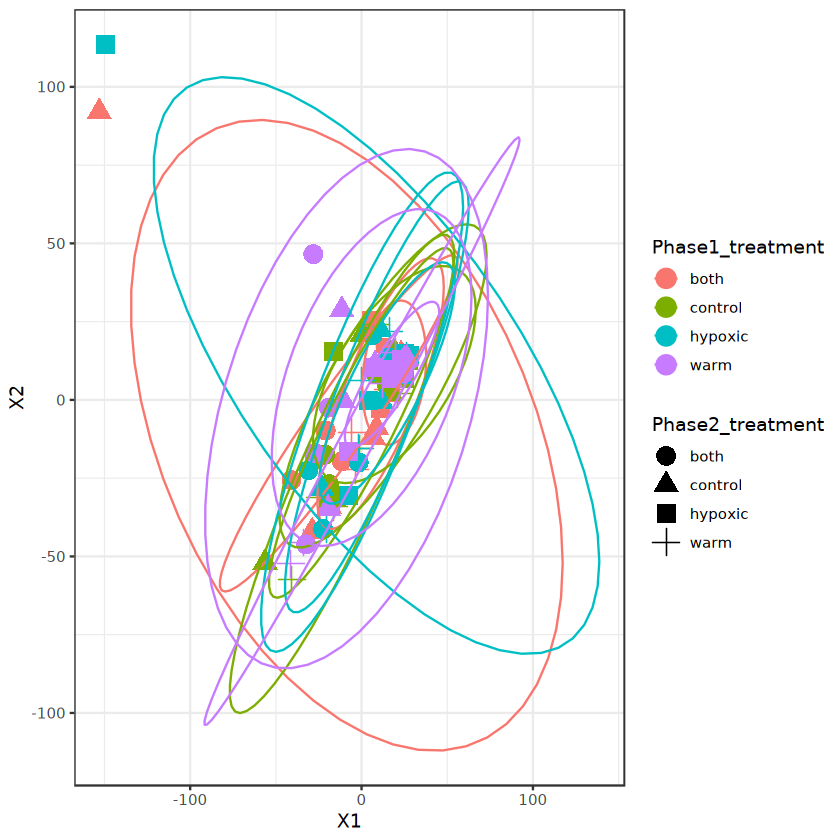

In [13]:
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_treatment, shape = Phase2_treatment)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw()

nmds.plot

## permANOVA

In [17]:
sample_dists <- dist(t(assay(vsd)))  # transpose so samples are rows
head(sample_dists)

meta <- as.data.frame(colData(vsd))
head(meta)

[1] 112.8736 115.3262 107.8979 115.2555 113.4817 122.9179

,Phase1_treatment,Phase1_temp,Phase1_DO,Phase1_TankRep,Phase2_treatment,Phase2_temp,Phase2_DO,Phase2_TankRep,complete_trtmt,sizeFactor
,<chr>,<fct>,<fct>,<int>,<chr>,<fct>,<fct>,<int>,<fct>,<dbl>
B1_B1_O01,both,warm,hypoxic,1,both,warm,hypoxic,1,both both,1.0714460
B1_W5_O50,both,warm,hypoxic,1,warm,warm,normoxic,5,both warm,1.0125468
B2_B5_O51,both,warm,hypoxic,2,both,warm,hypoxic,5,both both,1.0641357
B2_C4_O40,both,warm,hypoxic,2,control,ambient,normoxic,4,both control,1.1577371
B3_B4_O41,both,warm,hypoxic,3,both,warm,hypoxic,4,both both,0.8702869
B3_C3_O30,both,warm,hypoxic,3,control,ambient,normoxic,3,both control,0.8565139


In [18]:
adonis2(sample_dists ~ Phase1_temp * Phase1_DO * Phase2_temp * Phase2_DO, data = meta, permutations = 999)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Phase1_temp,1,6436.659,0.009290143,0.8849709,0.681
Phase1_DO,1,5969.374,0.008615702,0.8207242,0.827
Phase2_temp,1,13573.403,0.019590729,1.8661956,0.005
Phase2_DO,1,9153.680,0.013211666,1.2585317,0.120
Phase1_temp:Phase1_DO,1,5134.389,0.007410554,0.7059228,0.971
Phase1_temp:Phase2_temp,1,5290.850,0.007636376,0.7274345,0.937
Phase1_DO:Phase2_temp,1,6350.438,0.009165698,0.8731164,0.698
Phase1_temp:Phase2_DO,1,6029.998,0.008703202,0.8290594,0.820
Phase1_DO:Phase2_DO,1,6800.014,0.009814579,0.9349282,0.568


- Phase2_temp has a significant effect on GE (P = 0.005) and explains ~1.9% of the variation in GE
- The interaction of Phase2_temp and Phase2_DO is nearly significant (P = 0.094) and explains ~1.3% of the variation in GE
- The majoirty of the variation in GE is not explained by the treatments (R2 = 0.84)

## Pairwise comparisons

### 1. Priming vs. No Priming
What is the effect of early stress exposures in the response to later exposures compared to oysters that do not experience priming?

#### 1A. Matched stressors
Oyster is primed with a stress, and experiences the *same* stressor again
- HH vs. CH
- WW vs. CW
- BB vs. CB

#### HH vs. CH

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 881, 2.5%
LFC < 0 (down)     : 214, 0.6%
outliers [1]       : 1060, 3%
low counts [2]     : 683, 1.9%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”


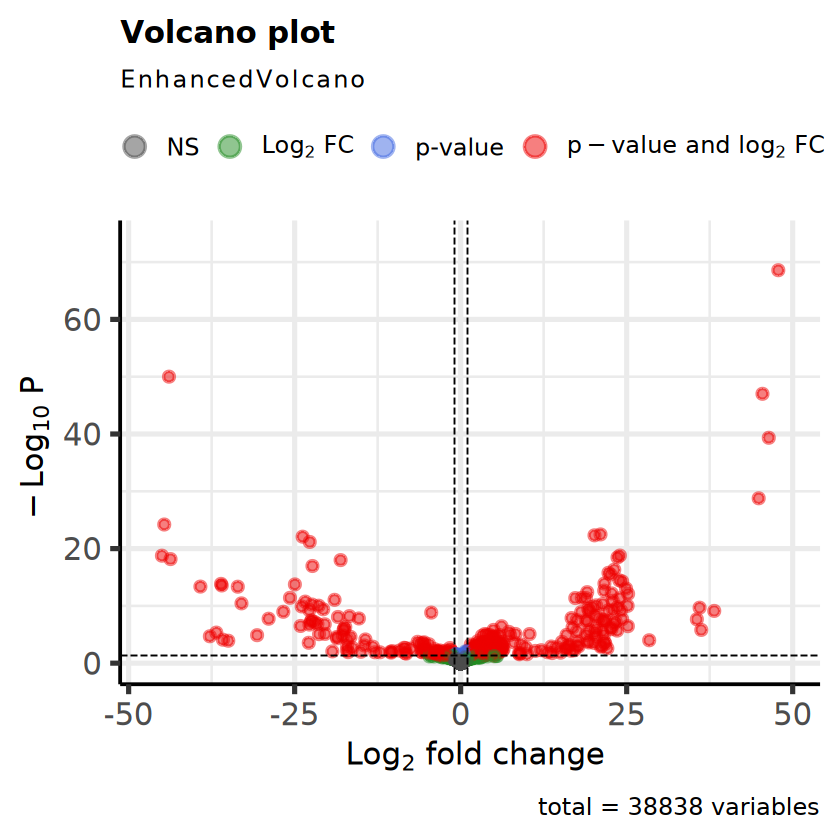

In [20]:
res.hh.ch <- lfcShrink(dds, contrast= c('complete_trtmt', 'hypoxic.hypoxic', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr')

summary(res.hh.ch)

EnhancedVolcano(res.hh.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [38]:
write.csv(res.hh.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/hh_ch.csv')

#### WW vs. CW

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 105, 0.3%
LFC < 0 (down)     : 92, 0.26%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



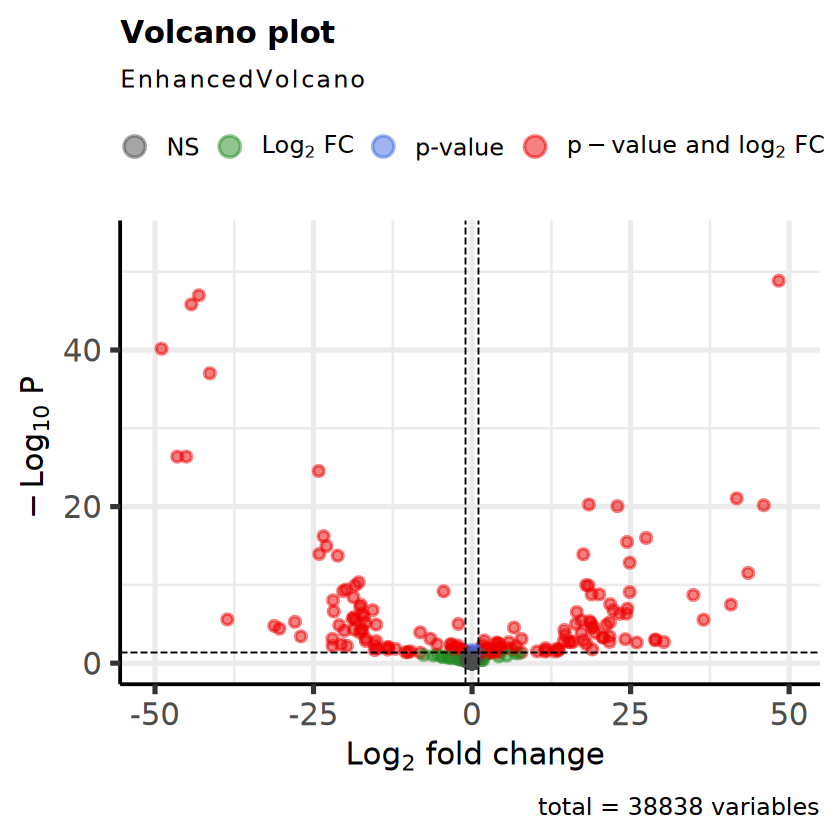

In [22]:
res.ww.cw <- lfcShrink(dds, contrast= c('complete_trtmt', 'warm.warm', 'control.warm'), # CW is the "control"
                     type = 'ashr')

summary(res.ww.cw)

EnhancedVolcano(res.ww.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [37]:
write.csv(res.ww.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/ww_cw.csv')

#### BB vs. CB

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 92, 0.26%
LFC < 0 (down)     : 191, 0.54%
outliers [1]       : 1060, 3%
low counts [2]     : 2041, 5.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



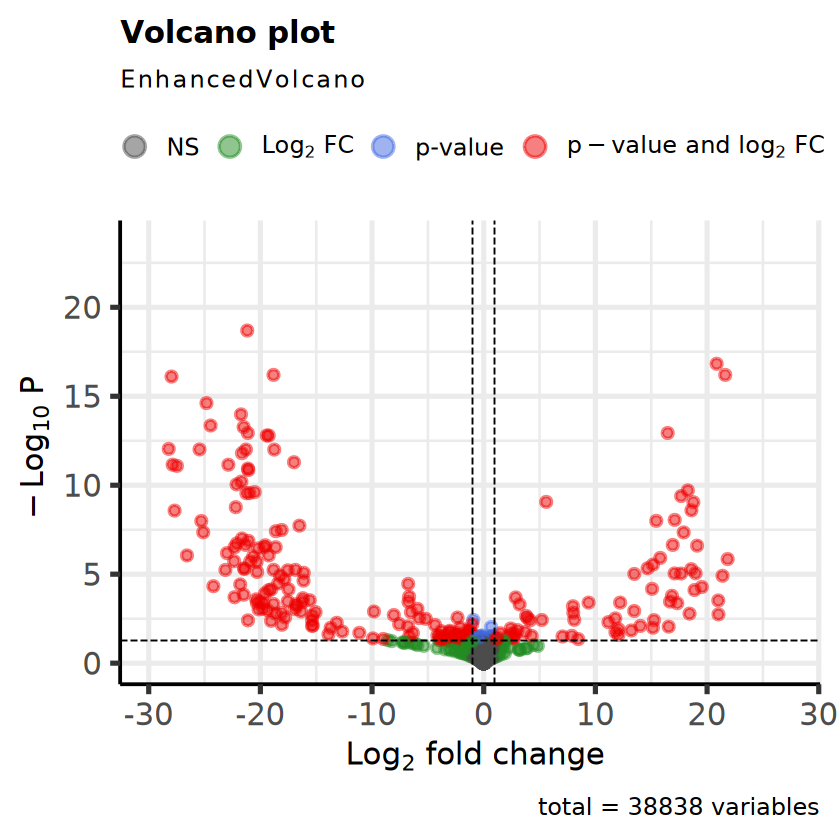

In [34]:
res.cb.bb <- lfcShrink(dds, 
                       coef= 'complete_trtmt_control.both_vs_both.both', # BB is the "control"
                       type = 'ashr')

summary(res.cb.bb)

EnhancedVolcano(res.cb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [36]:
write.csv(res.cb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/cb_bb.csv')

#### 1B. Semi-matched stressors
Oyster is primed with a stress, and experiences the same stressor with an additional novel stressor
- WB vs. CB
- HB vs. CB

#### WB vs. CB

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 223, 0.63%
LFC < 0 (down)     : 125, 0.35%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



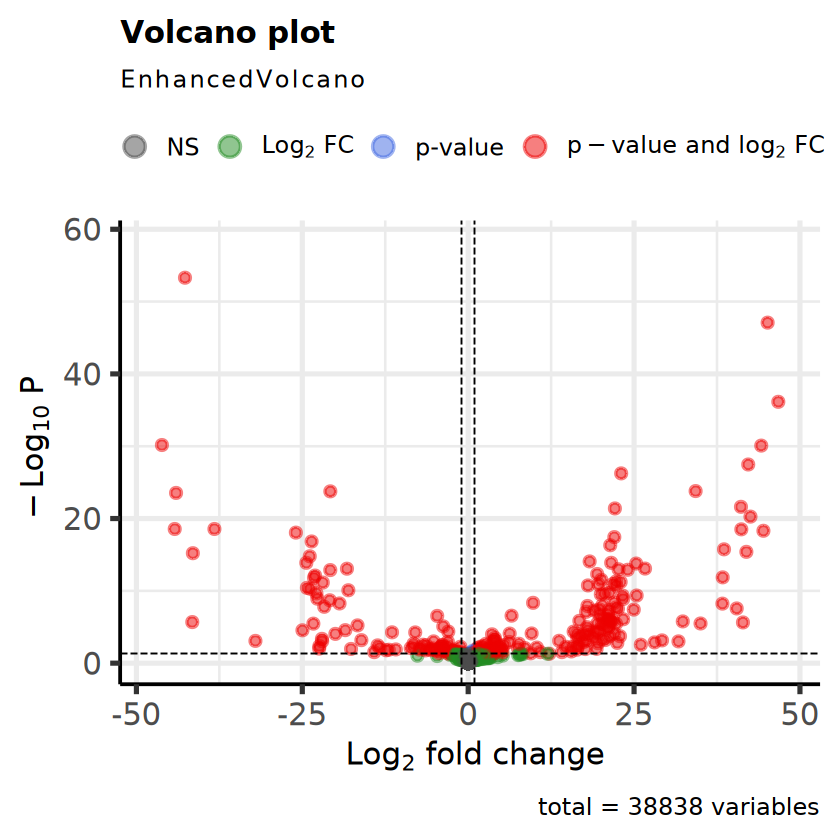

In [42]:
res.wb.cb <- lfcShrink(dds, contrast= c('complete_trtmt', 'warm.both', 'control.both'), # CB is the "control"
                     type = 'ashr')

summary(res.wb.cb)

EnhancedVolcano(res.wb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [43]:
write.csv(res.wb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/wb_cb.csv')

#### HB vs. CB

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 130, 0.37%
LFC < 0 (down)     : 90, 0.25%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



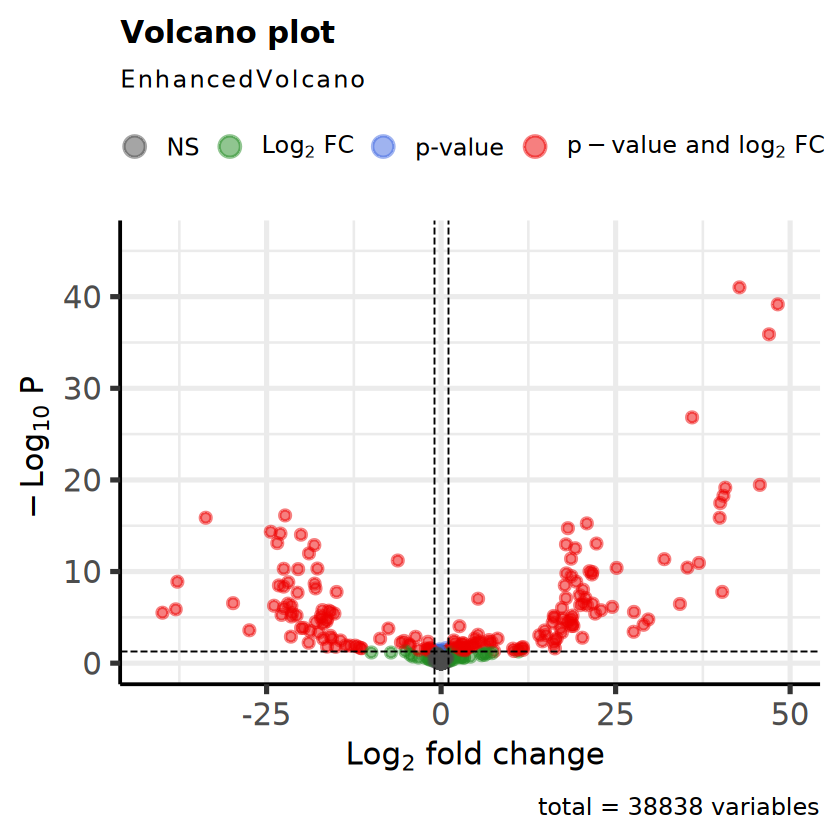

In [44]:
res.hb.cb <- lfcShrink(dds, contrast= c('complete_trtmt', 'hypoxic.both', 'control.both'), # CB is the "control"
                     type = 'ashr')

summary(res.hb.cb)

EnhancedVolcano(res.hb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [45]:
write.csv(res.hb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/hb_cb.csv')

### 2. Sinlge vs. Multiple Stress Priming
Is it better to be primed with a single stressor or multiple stressor, depending on the context of the future enviornment (single/multiple stressor)?

#### 2A. when later exposed to single stressors
Oyster is primed with either multiple or a single stressors, and then experiences only a sinlge stressor later
- BH vs. HH
- BW vs. WW

#### BH vs. HH

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 614, 1.7%
LFC < 0 (down)     : 1277, 3.6%
outliers [1]       : 1060, 3%
low counts [2]     : 2041, 5.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



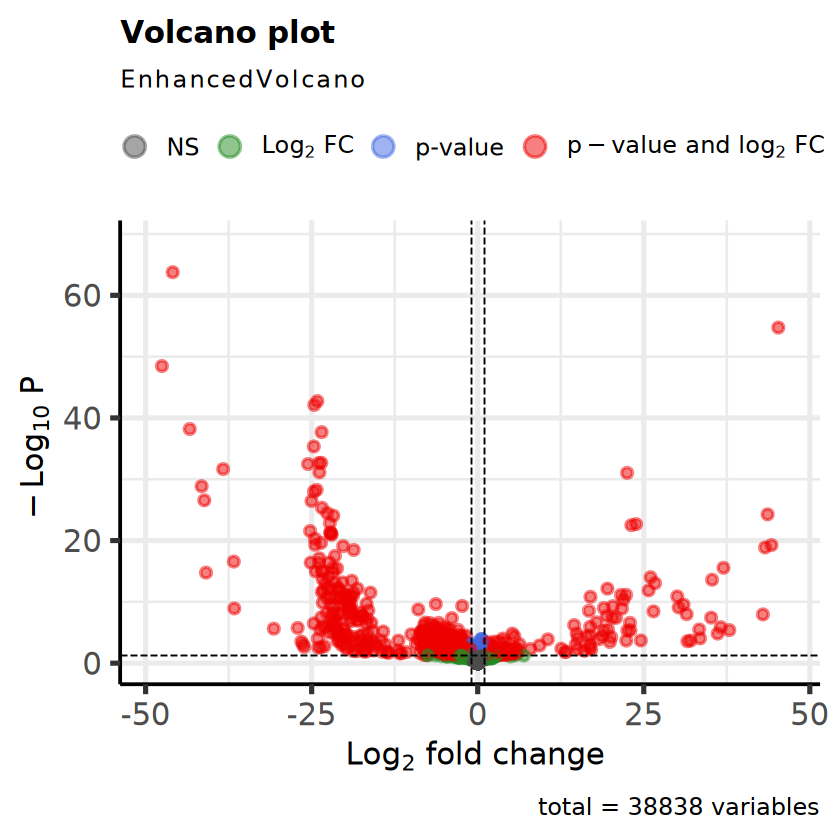

In [46]:
res.hh.bh <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.hypoxic', 'hypoxic.hypoxic'), # HH is the "control"
                     type = 'ashr')

summary(res.hh.bh)

EnhancedVolcano(res.hh.bh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [47]:
write.csv(res.hh.bh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/bh_hh.csv')

#### BW vs. WW

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 125, 0.35%
LFC < 0 (down)     : 183, 0.52%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



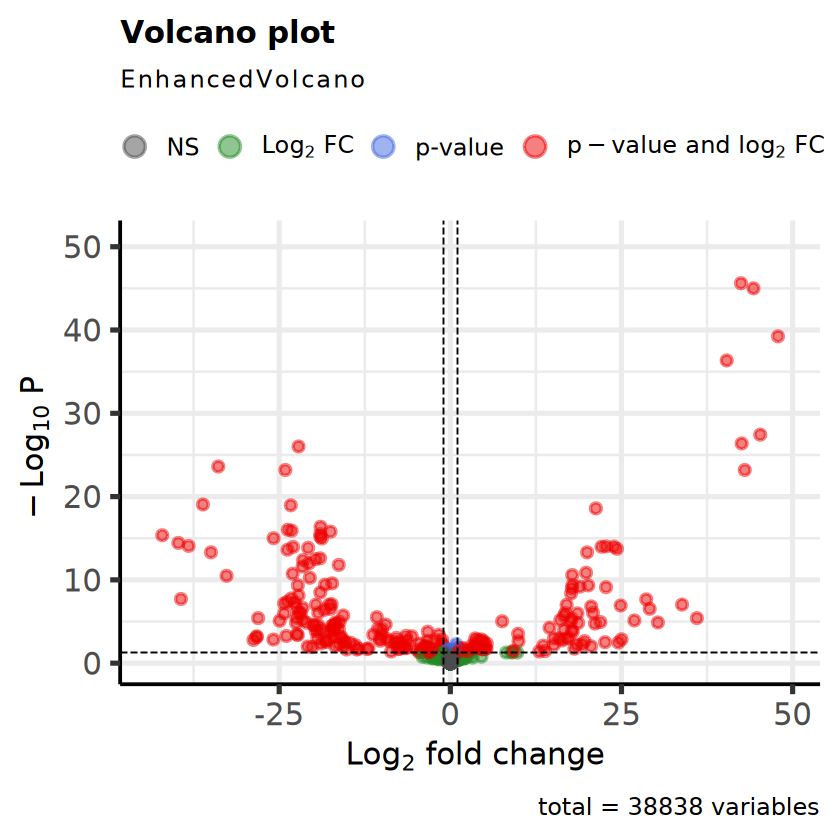

In [48]:
res.bw.ww <- lfcShrink(dds, contrast= c('complete_trtmt', 'both.warm', 'warm.warm'), # WW is the "control"
                     type = 'ashr')

summary(res.bw.ww)

EnhancedVolcano(res.bw.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [49]:
write.csv(res.bw.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/bw_ww.csv')

#### 2B. when later exposed to single stressors
Oyster is primed with either multiple or a single stressors, and then experiences multiple stressors later
- HB vs. BB
- WB vs. BB

#### HB vs. BB

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 115, 0.32%
LFC < 0 (down)     : 160, 0.45%
outliers [1]       : 1060, 3%
low counts [2]     : 683, 1.9%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



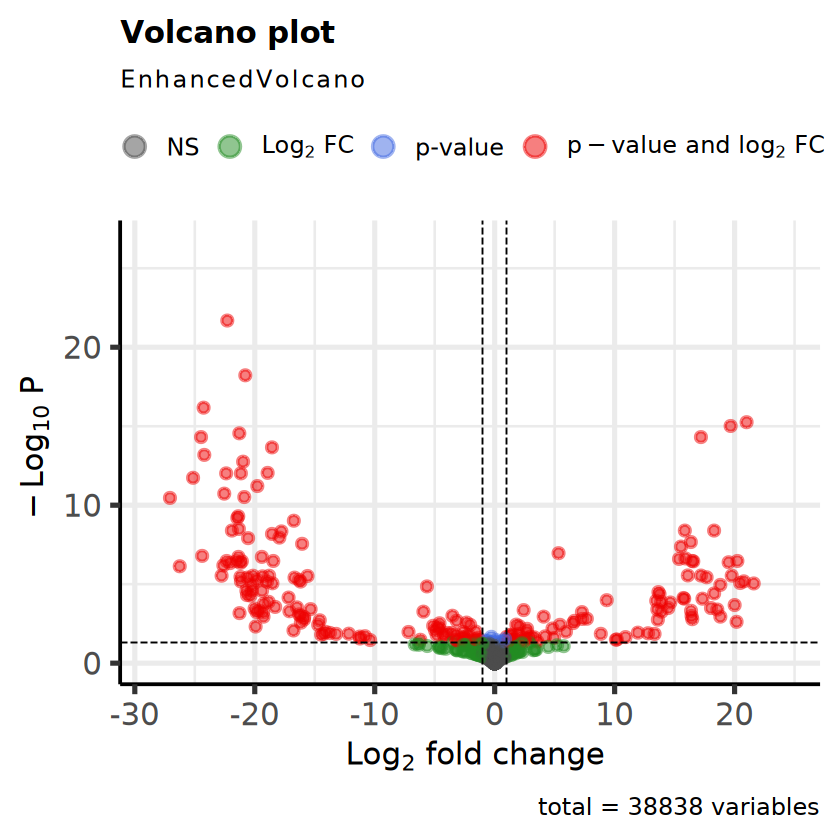

In [54]:
res.hb.bb <- lfcShrink(dds, 
                       coef= 'complete_trtmt_hypoxic.both_vs_both.both', # BB is the "control"
                     type = 'ashr')

summary(res.hb.bb)

EnhancedVolcano(res.hb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [55]:
write.csv(res.hb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/hb_bb.csv')

#### WB vs. BB

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 107, 0.3%
LFC < 0 (down)     : 106, 0.3%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



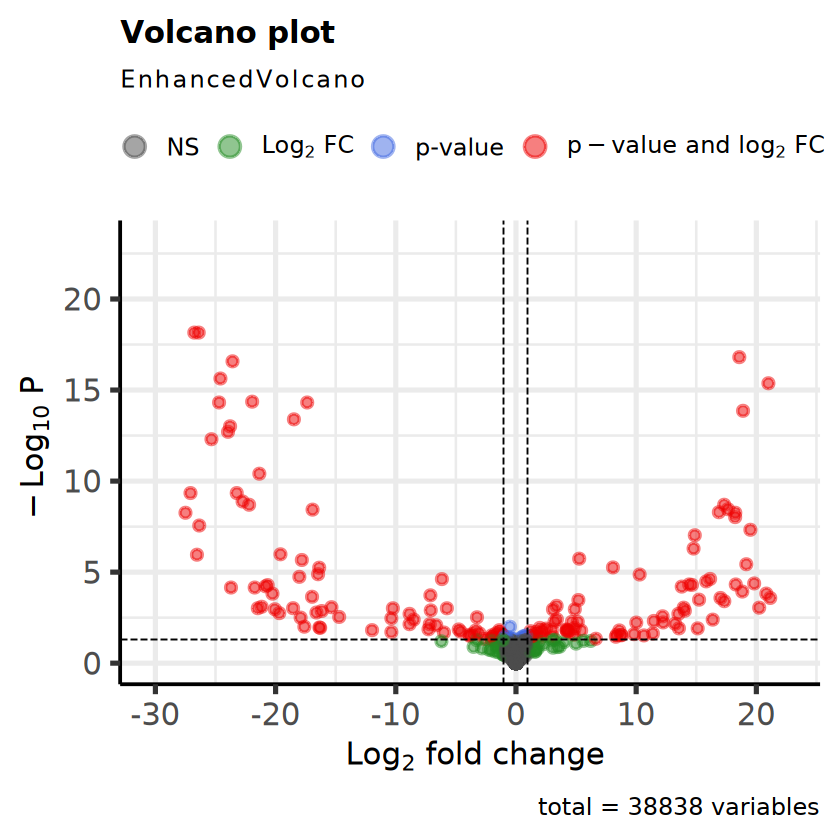

In [56]:
res.wb.bb <- lfcShrink(dds, 
                       coef= 'complete_trtmt_warm.both_vs_both.both', # BB is the "control"
                     type = 'ashr')

summary(res.wb.bb)

EnhancedVolcano(res.wb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [57]:
write.csv(res.wb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/wb_bb.csv')

### 3. Timing of Stress Exposure
How does GE change depending on when stress is experienced (when all oysters only experience stress once)?
- CH vs. HC
- CW vs. WC
- CB vs. BC

#### CH vs. HC - timing of hypoxic stress

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 141, 0.4%
LFC < 0 (down)     : 173, 0.49%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



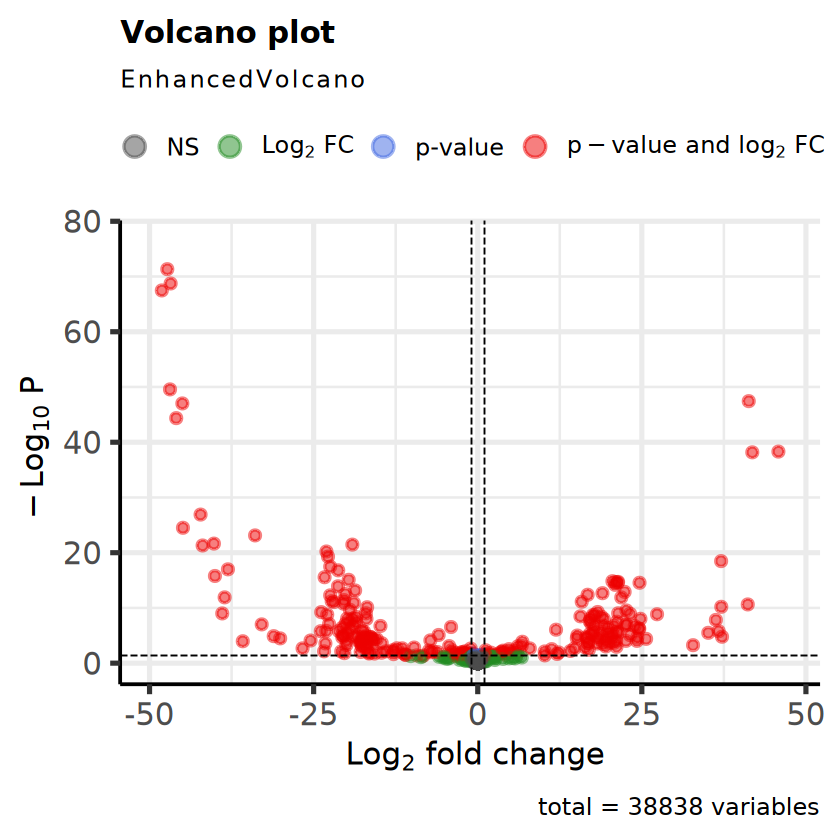

In [58]:
res.hc.ch <- lfcShrink(dds, contrast = c('complete_trtmt', 'hypoxic.control', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr')

summary(res.hc.ch)

EnhancedVolcano(res.hc.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [59]:
write.csv(res.hc.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/hc_ch.csv')

#### CW vs. WC - timing of warm stress

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 165, 0.47%
LFC < 0 (down)     : 190, 0.54%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



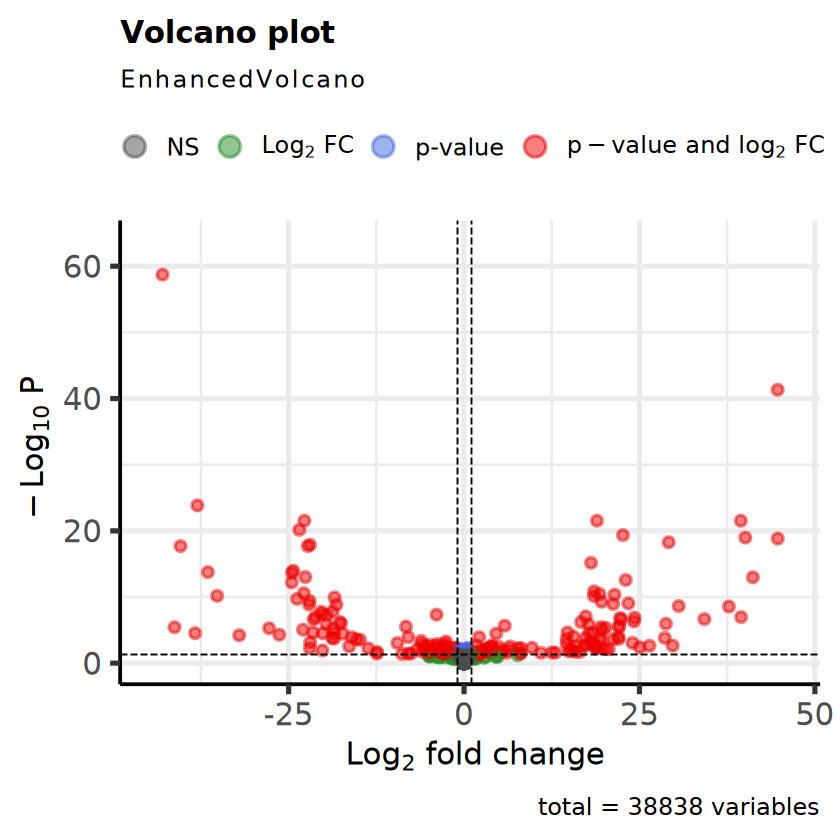

In [60]:
res.wc.cw <- lfcShrink(dds, contrast = c('complete_trtmt', 'warm.control', 'control.warm'), # CW is the "control"
                     type = 'ashr')

summary(res.wc.cw)

EnhancedVolcano(res.wc.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [61]:
write.csv(res.wc.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/wc_cw.csv')

#### CB vs. BC - timing of multiple stressors

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1074, 3%
LFC < 0 (down)     : 425, 1.2%
outliers [1]       : 1060, 3%
low counts [2]     : 2041, 5.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



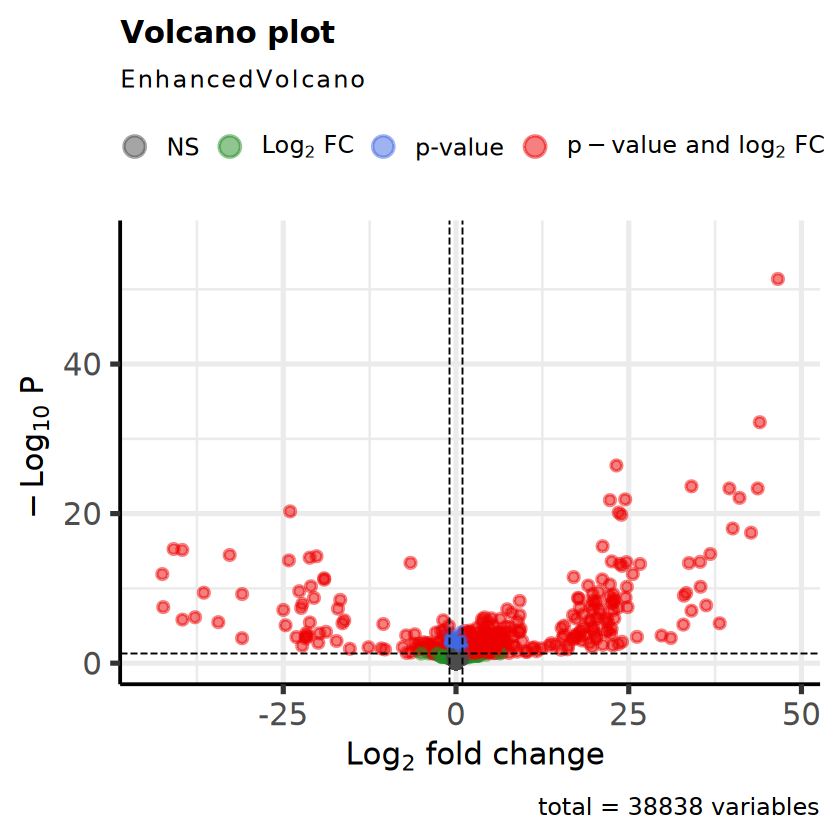

In [62]:
res.bc.cb <- lfcShrink(dds, contrast = c('complete_trtmt', 'both.control', 'control.both'), # CB is the "control"
                     type = 'ashr')

summary(res.bc.cb)

EnhancedVolcano(res.bc.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [63]:
write.csv(res.bc.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/bc_cb.csv')

### 4. Effect of Early Exposure in Subseqeunt Response
Oysters all experience the same early stressor, but either return to that stressor or experience control conditions
- HC vs. HH
- WC vs. WW
- BB vs. BC

#### HC vs. HH

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 204, 0.58%
LFC < 0 (down)     : 948, 2.7%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



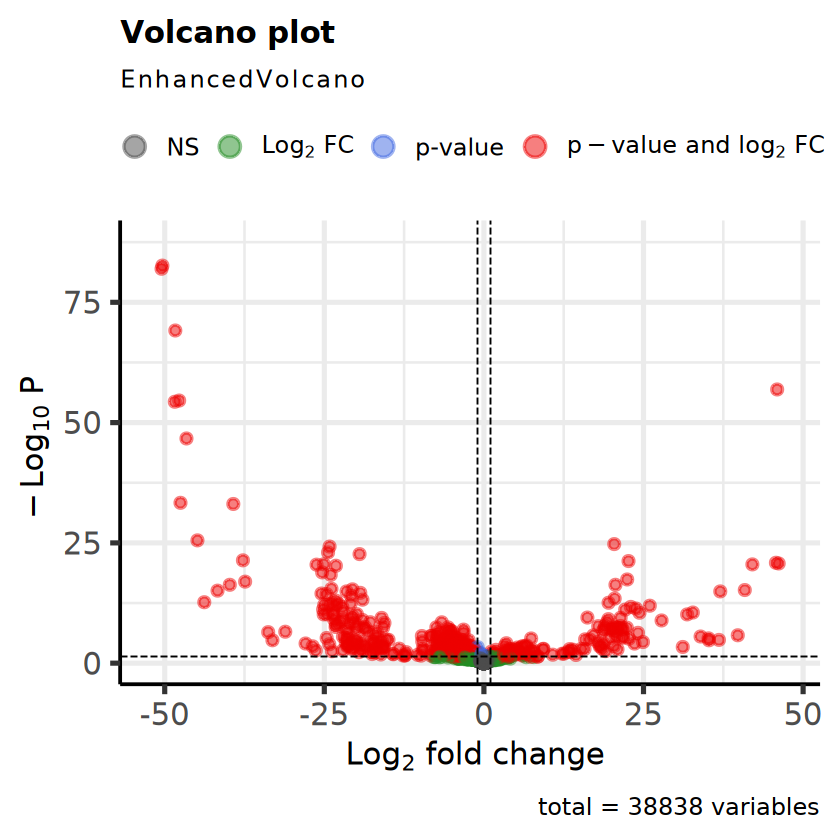

In [64]:
res.hc.hh <- lfcShrink(dds, contrast = c('complete_trtmt', 'hypoxic.control', 'hypoxic.hypoxic'), # HH is the "control"
                     type = 'ashr')

summary(res.hc.hh)

EnhancedVolcano(res.hc.hh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [65]:
write.csv(res.hc.hh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/hc_hh.csv')

#### WC vs. WW

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 149, 0.42%
LFC < 0 (down)     : 160, 0.45%
outliers [1]       : 1060, 3%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



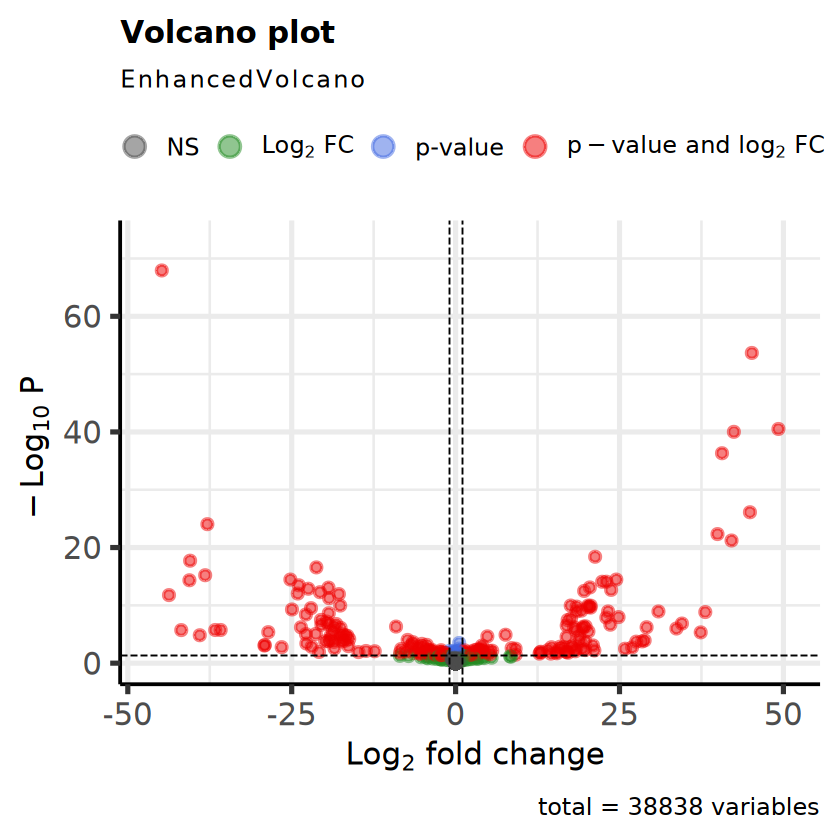

In [66]:
res.wc.ww <- lfcShrink(dds, contrast = c('complete_trtmt', 'warm.control', 'warm.warm'), # WW is the "control"
                     type = 'ashr')

summary(res.wc.ww)

EnhancedVolcano(res.wc.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [67]:
write.csv(res.wc.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/wc_ww.csv')

#### BC vs. BB

In [69]:
resultsNames(dds)

[1] "Intercept"                                  
 [2] "complete_trtmt_both.control_vs_both.both"   
 [3] "complete_trtmt_both.hypoxic_vs_both.both"   
 [4] "complete_trtmt_both.warm_vs_both.both"      
 [5] "complete_trtmt_control.both_vs_both.both"   
 [6] "complete_trtmt_control.control_vs_both.both"
 [7] "complete_trtmt_control.hypoxic_vs_both.both"
 [8] "complete_trtmt_control.warm_vs_both.both"   
 [9] "complete_trtmt_hypoxic.both_vs_both.both"   
[10] "complete_trtmt_hypoxic.control_vs_both.both"
[11] "complete_trtmt_hypoxic.hypoxic_vs_both.both"
[12] "complete_trtmt_hypoxic.warm_vs_both.both"   
[13] "complete_trtmt_warm.both_vs_both.both"      
[14] "complete_trtmt_warm.control_vs_both.both"   
[15] "complete_trtmt_warm.hypoxic_vs_both.both"   
[16] "complete_trtmt_warm.warm_vs_both.both"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 535, 1.5%
LFC < 0 (down)     : 223, 0.63%
outliers [1]       : 1060, 3%
low counts [2]     : 2690, 7.6%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



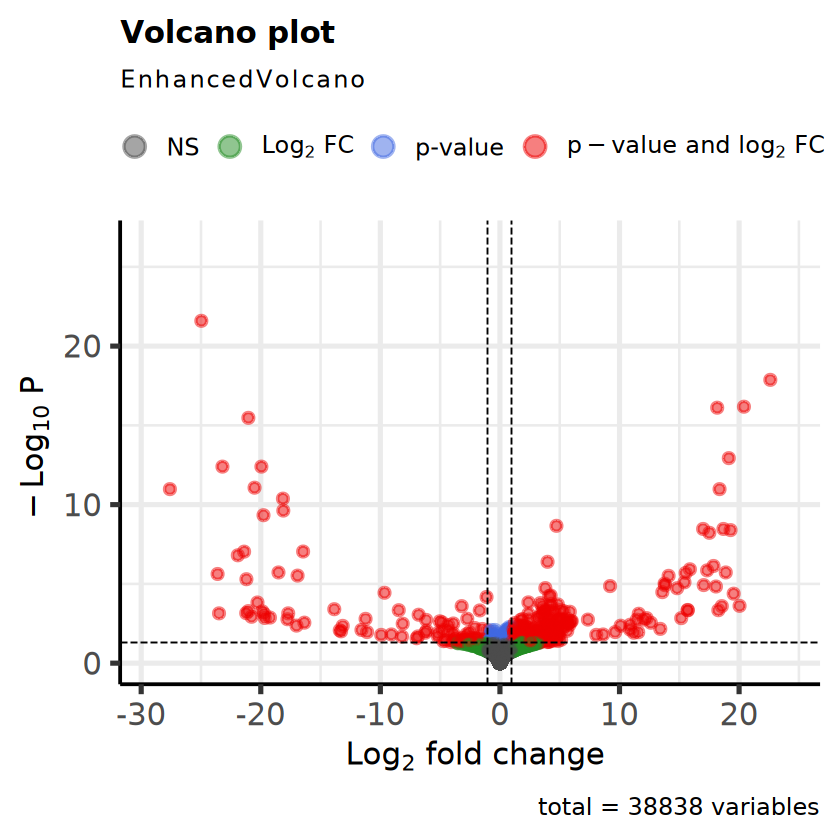

In [70]:
res.bc.bb <- lfcShrink(dds, coef = 'complete_trtmt_both.control_vs_both.both', # BB is the "control"
                     type = 'ashr')

summary(res.bc.bb)

EnhancedVolcano(res.bc.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [72]:
write.csv(res.bc.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/bc_bb.csv')

### 5. Shared/Unique Repsonses in ...

#### 5A. Different *early* stress exposure
>can compare these with the phase 1 vs. phase 1 DEGs to see if there are similarities
- WC vs. HC: single early stress
- BC vs. HC: mulitple vs. single
- BC vs. WC: multiple vs. single

#### WC vs. HC

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 194, 0.55%
LFC < 0 (down)     : 115, 0.32%
outliers [1]       : 1060, 3%
low counts [2]     : 2690, 7.6%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



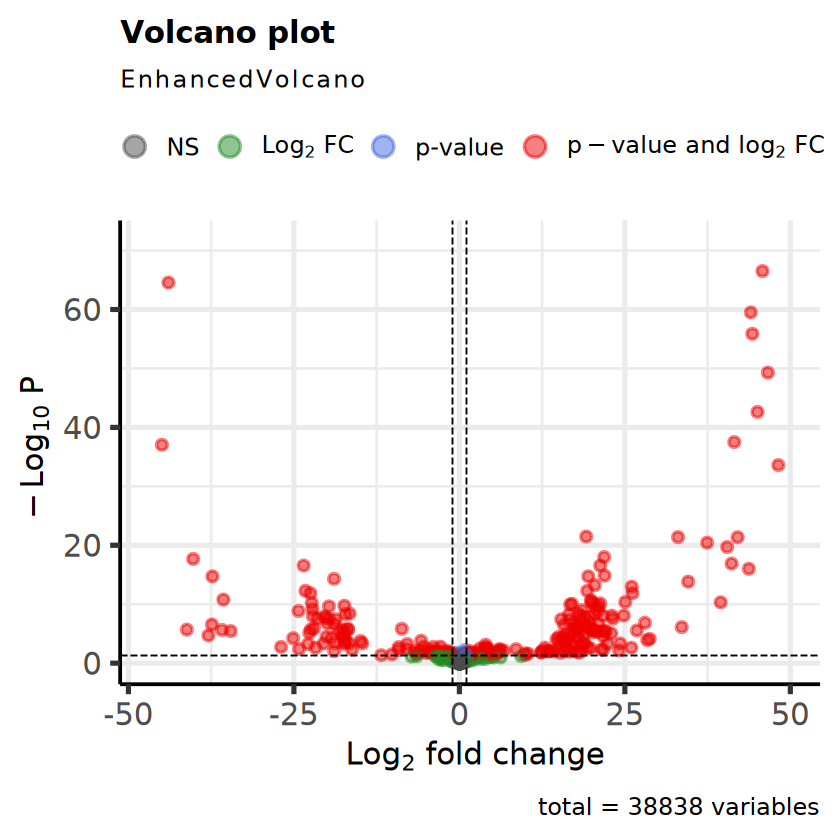

In [73]:
res.wc.hc <- lfcShrink(dds, contrast=c('complete_trtmt', 'warm.control', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr')

summary(res.wc.hc)

EnhancedVolcano(res.wc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [74]:
write.csv(res.wc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/wc_hc.csv')

#### BC vs. HC

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 702, 2%
LFC < 0 (down)     : 120, 0.34%
outliers [1]       : 1060, 3%
low counts [2]     : 1367, 3.9%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



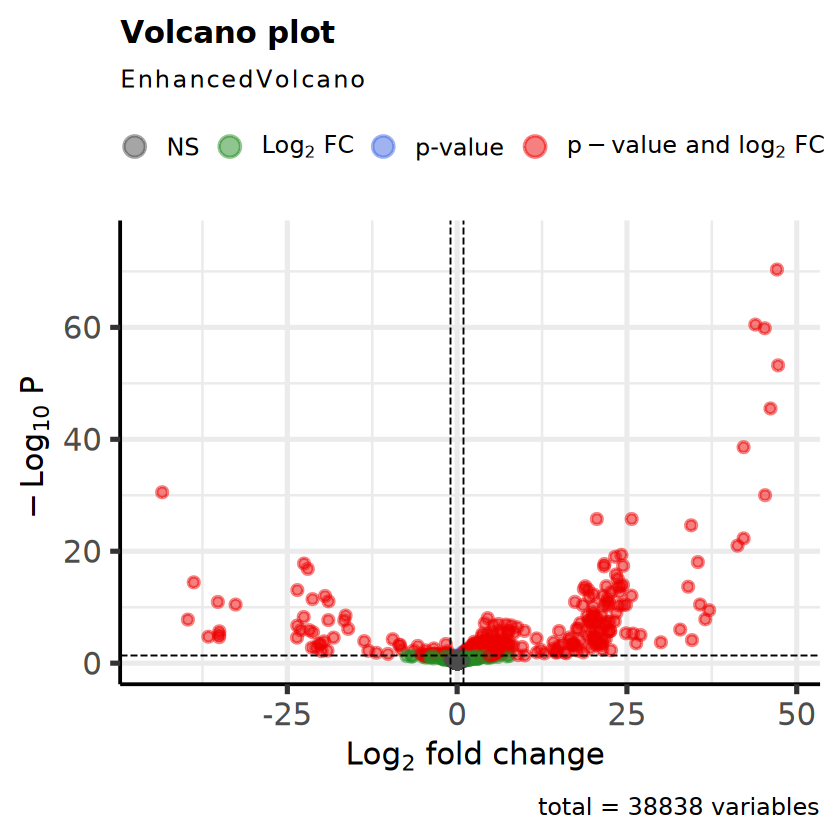

In [75]:
res.bc.hc <- lfcShrink(dds, contrast=c('complete_trtmt', 'both.control', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr')

summary(res.bc.hc)

EnhancedVolcano(res.bc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [76]:
write.csv(res.bc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/bc_hc.csv')

#### BC vs. WC

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041




out of 35412 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 477, 1.3%
LFC < 0 (down)     : 119, 0.34%
outliers [1]       : 1060, 3%
low counts [2]     : 2041, 5.8%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



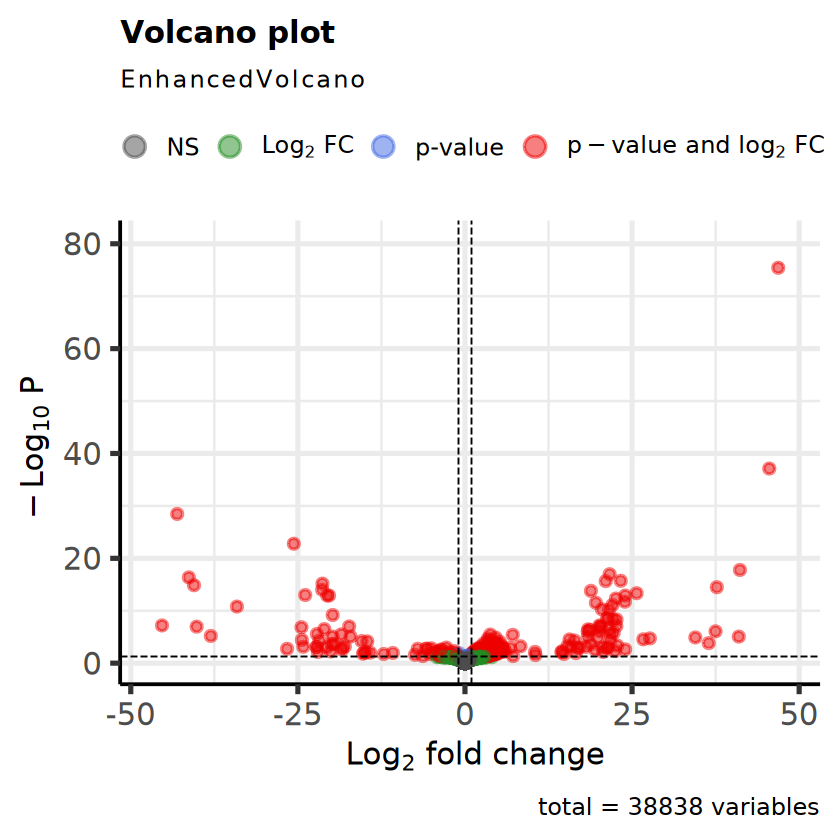

In [77]:
res.bc.wc <- lfcShrink(dds, contrast=c('complete_trtmt', 'both.control', 'warm.control'), # WC is the "control"
                     type = 'ashr')

summary(res.bc.wc)

EnhancedVolcano(res.bc.wc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

In [78]:
write.csv(res.bc.wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/bc_wc.csv')

#### 5B. Different *later* stress exposure
- CW vs. CH: single early stress
- CB vs. CH: mulitple vs. single
- CB vs. CW: multiple vs. single

#### CW vs. CH